In [1]:
#type = Ignore
#Importing packages
import torch
import torch.nn as nn
import torch.optim as optim
from AEModel import AE, MyDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Reading Dataset

In [2]:
#Read files
cnv_df= pd.read_csv("../../data/master_cnv_df.csv",encoding = "UTF-8")


In [3]:
#type(gene_df.iloc[:,1:].shape[1])
cnv_df.iloc[:,1:].head()

,OR4F5,OR4F29,OR4F16,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,...,PRY,BPY2,DAZ1,DAZ2,CDY1B,BPY2B,DAZ3,DAZ4,BPY2C,CDY1
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# DataLoader is used to load the dataset for training
pd_train_dataset, pd_test_dataset = train_test_split(cnv_df.iloc[:,1:], test_size=0.2)

X_train_sc = StandardScaler().fit_transform(pd_train_dataset)

X_test_sc = StandardScaler().fit_transform(pd_test_dataset)

X_full_sc = StandardScaler().fit_transform(cnv_df.iloc[:,1:])

In [5]:
data_train = MyDataset(X_train_sc)
data_test = MyDataset(X_test_sc)
data_full = MyDataset(X_full_sc)

In [6]:
train_loader=DataLoader(data_train, batch_size=50, shuffle=False)
test_loader = DataLoader(data_test, batch_size=50)

In [7]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape = len(X_train_sc[0])).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [8]:
losses_train = []
losses_val = []

epochs=700
for epoch in range(epochs):
    model.train()
    loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        lol, outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    losses_train.append(loss)


    #For Valid Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            code, outputs = model(batch)
            loss_val =criterion(outputs, batch)
            val_loss += loss_val.item()

    val_loss = val_loss / len(test_loader)
    losses_val.append(val_loss)


    # display the epoch training loss
    print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, loss))
    print("epoch : {}/{}, val_loss = {:.6f}".format(epoch + 1, epochs, val_loss))

epoch : 1/700, train_loss = 1.186182
epoch : 1/700, val_loss = 1.443389
epoch : 2/700, train_loss = 0.725171
epoch : 2/700, val_loss = 0.909317
epoch : 3/700, train_loss = 0.634373
epoch : 3/700, val_loss = 0.617501
epoch : 4/700, train_loss = 0.592686
epoch : 4/700, val_loss = 0.539665
epoch : 5/700, train_loss = 0.562802
epoch : 5/700, val_loss = 0.519412
epoch : 6/700, train_loss = 0.537065
epoch : 6/700, val_loss = 0.503184
epoch : 7/700, train_loss = 0.512035
epoch : 7/700, val_loss = 0.489772
epoch : 8/700, train_loss = 0.488999
epoch : 8/700, val_loss = 0.474468
epoch : 9/700, train_loss = 0.467107
epoch : 9/700, val_loss = 0.458449
epoch : 10/700, train_loss = 0.447448
epoch : 10/700, val_loss = 0.444890
epoch : 11/700, train_loss = 0.429307
epoch : 11/700, val_loss = 0.431447
epoch : 12/700, train_loss = 0.412091
epoch : 12/700, val_loss = 0.417985
epoch : 13/700, train_loss = 0.398531
epoch : 13/700, val_loss = 0.412797
epoch : 14/700, train_loss = 0.386821
epoch : 14/700, va

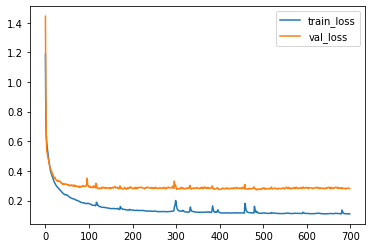

In [10]:
plt.plot(losses_train, label = 'train_loss')
plt.plot(losses_val, label = 'val_loss')
plt.legend()
plt.savefig("../../Figures/AE_cnv.png", dpi = 400)

In [11]:
data = torch.tensor(X_full_sc,dtype=torch.float32)

In [12]:
# Full Gene Autoencoder Taining

data_full = MyDataset(X_full_sc)
full_loader = DataLoader(data_full, batch_size=50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(input_shape = len(X_full_sc[0])).to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
criterion = nn.MSELoss()



In [13]:
losses_train_final = []

epochs=100
for epoch in range(epochs):
    model.train()
    loss = 0
    for batch_features in full_loader:
        batch_features = batch_features.to(device)
        
        optimizer.zero_grad()
        
        code, outputs = model(batch_features)
        
        train_loss = criterion(outputs, batch_features)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    losses_train_final.append(loss)

    print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/100, train_loss = 1.350110
epoch : 2/100, train_loss = 0.824939
epoch : 3/100, train_loss = 0.749920
epoch : 4/100, train_loss = 0.702631
epoch : 5/100, train_loss = 0.662834
epoch : 6/100, train_loss = 0.626659
epoch : 7/100, train_loss = 0.593370
epoch : 8/100, train_loss = 0.561592
epoch : 9/100, train_loss = 0.532784
epoch : 10/100, train_loss = 0.508384
epoch : 11/100, train_loss = 0.488393
epoch : 12/100, train_loss = 0.471875
epoch : 13/100, train_loss = 0.457809
epoch : 14/100, train_loss = 0.444228
epoch : 15/100, train_loss = 0.430415
epoch : 16/100, train_loss = 0.420101
epoch : 17/100, train_loss = 0.411300
epoch : 18/100, train_loss = 0.404620
epoch : 19/100, train_loss = 0.396524
epoch : 20/100, train_loss = 0.387928
epoch : 21/100, train_loss = 0.380161
epoch : 22/100, train_loss = 0.374433
epoch : 23/100, train_loss = 0.370264
epoch : 24/100, train_loss = 0.365195
epoch : 25/100, train_loss = 0.361014
epoch : 26/100, train_loss = 0.356363
epoch : 27/100, train

In [14]:
model.eval()
with torch.no_grad():
    out,out2 = model(data)

In [15]:
latent_df = pd.DataFrame(out)
latent_df.insert(0,'file_name',cnv_df['file_name'])
latent_df

,file_name,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,41fc6849-724a-4bac-8775-5e703fe74184,-0.974156,0.640870,0.954011,-0.290834,-0.895645,0.305227,-0.743481,-0.722786,0.743691,...,-0.779438,-0.282916,1.046016,-0.897457,-1.595210,-0.421787,0.261736,-0.015702,-0.602377,-1.009496
1,0f6b347c-30da-495b-b103-36af30df77d7,-1.076514,-0.841759,-0.723073,0.847657,-0.414650,-0.830574,-0.743481,-0.722786,-0.757991,...,-0.606827,-0.673909,0.462093,-0.897457,-0.223368,-1.191027,2.811174,0.781487,2.521043,1.981540
2,6568ed2b-0018-4750-9b3b-6c414dba60ae,0.795264,-0.361459,0.818655,0.453412,-0.448078,-0.830574,-0.743481,-0.722786,1.411721,...,-0.779438,-0.036675,0.525036,-0.897457,-0.325024,0.273792,1.294912,-0.440448,-0.602377,1.385615
3,e18b7869-0049-4be7-9611-d08db28df33d,-1.096501,-0.841759,-0.723073,-0.602058,-0.959978,-0.830574,0.493545,-0.722786,-0.564996,...,-0.227359,-0.673909,-0.307242,-0.132606,-0.015206,-0.577474,-0.834728,-0.509095,0.683812,-1.009496
4,361cc367-f85d-402a-a19d-999d33f7667a,-1.246765,-0.841759,-0.723073,-0.798074,-1.634691,-0.830574,-0.743481,-0.722786,-0.937965,...,-0.427165,-0.673909,-1.114877,0.265582,-0.279157,-0.565246,-0.834728,-0.509095,-0.602377,-1.009496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,41811e19-d6bb-4f1c-ac67-9df06ad9f85b,-1.117414,-0.841759,-0.723073,-0.407473,-0.175871,-0.830574,0.208899,-0.722786,-0.937965,...,0.511187,-0.673909,-1.337603,0.698206,-0.373926,-0.383705,-0.834728,-0.509095,-0.232455,-1.009496
950,409bd257-5ce4-4a03-a7a8-c9c8e697fb39,-0.518656,-0.841759,-0.723073,-0.802269,-0.282307,-0.830574,-0.004733,-0.722786,-0.683462,...,-0.301082,-0.673909,-0.208951,-0.897457,-0.307497,0.202201,-0.834728,-0.509095,0.101116,-0.276592
951,d9e3e564-e9c8-416c-8a25-91e6744b1472,-0.360635,0.209288,-0.723073,-0.802269,-0.998645,-0.793644,-0.743481,-0.722786,0.008906,...,-0.779438,-0.673909,0.116199,-0.897457,0.394974,0.463602,-0.834728,0.030162,-0.602377,0.484565
952,fc1de880-73b1-4a71-a1e9-09c0591bfc8f,2.197401,1.283121,1.496613,1.100107,1.182862,1.571816,-0.743481,-0.722786,0.987760,...,-0.779438,1.848925,0.523951,-0.897457,-0.794214,1.821550,-0.321065,0.848350,-0.602377,-1.009496


In [16]:
latent_df.to_csv("../../data/cnv_df_128.csv", index=False)